<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational auto-encoder

In [25]:
!pip install torch_snippets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
from torch_snippets.torch_loader import Report
from torch_snippets import  *

In [9]:
trn_ds = datasets.MNIST(root='MNIST/',train=True,
                        transform=transforms.ToTensor(),
                        download=True)
test_ds = datasets.MNIST(root='MNIST/',train=False,
                        transform=transforms.ToTensor(),
                        download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 50.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.05MB/s]


In [16]:
trn_dl = DataLoader(trn_ds,batch_size=64,shuffle=True)
test_dl = DataLoader(test_ds,batch_size=64,shuffle=False)

In [19]:
test_ds

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [20]:
im,l = next(iter(trn_dl))

In [21]:
im[0].shape

torch.Size([1, 28, 28])

In [22]:
class VAE(nn.Module):
  def __init__(self,x_dim,h_dim1,h_dim2,z_dim):
    super(VAE,self).__init__()
    self.d1 = nn.Linear(x_dim,h_dim1)
    self.d2 = nn.Linear(h_dim1,h_dim2)
    self.d31 = nn.Linear(h_dim2,z_dim)
    self.d32 = nn.Linear(h_dim2,z_dim)
    self.d4 = nn.Linear(z_dim,h_dim2)
    self.d5 = nn.Linear(h_dim2,h_dim1)
    self.d6 = nn.Linear(h_dim1,x_dim)

  def encoder(self,x):
    h = F.relu(self.d1(x))
    h = F.relu(self.d2(h))
    return self.d31(h),self.d32(h)

  def sampling(self,mean,log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.rand_like(std)
    return eps.mul(std).add_(mean)

  def decoder(self,z):
    h = F.relu(self.d4(z))
    h = F.relu(self.d5(h))
    return F.sigmoid(self.d6(h))

  def forward(self,x):
    mean,log_var = self.encoder(x.view(-1,784))
    z = self.sampling(mean,log_var)
    return self.decoder(z),mean,log_var

In [23]:
def train_batch(data,model,optimizer,loss_fn):
  model.train()
  data  =  data.to(device)
  optimizer.zero_grad()
  recon_batch,mean,log_var =  model(data)
  loss,mse,kld  = loss_fn(recon_batch,data,mean,log_var)
  loss.backward()
  optimizer.step()
  return loss,mse,kld,log_var.mean(),mean.mean()

@torch.no_grad()
def  validate_batch(data,model,loss_fn):
  model.eval()
  data =  data.to(device)
  recon,mean,log_var =  model(data)
  loss,mse,kld = loss_fn(recon,data,mean,log_var)
  return loss,mse,kld,log_var.mean(),mean.mean()

def loss_fn(recon_x,x,mean,log_var):
  RECON = F.mse_loss(recon_x,x.view(-1,784),reduction='sum')
  kld = -0.5 * torch.sum(1+log_var-mean.pow(2)-log_var.exp())
  return RECON+kld,RECON,kld

In [24]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

In [28]:
torch.manual_seed(1234)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH: 1.000  val_recon: 751.389  val_loss: 1055.105  trn_kld: 301.396  val_mean: -0.005  trn_recon: 758.903  val_log_var: -0.186  trn_log_var: -0.185  val_kld: 303.716  trn_loss: 1060.298  (41.91s - 377.21s remaining)


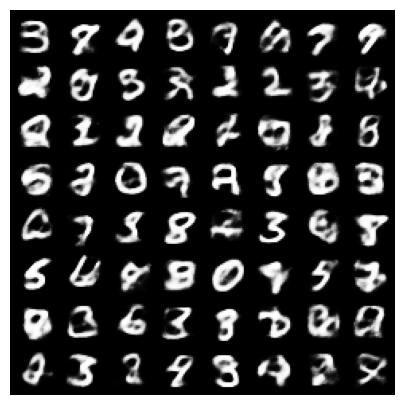

 10%|█         | 1/10 [00:41<06:17, 41.99s/it]

EPOCH: 2.000  val_recon: 739.047  val_loss: 1036.163  trn_kld: 301.580  val_mean: -0.005  trn_recon: 745.500  val_log_var: -0.182  trn_log_var: -0.185  val_kld: 297.116  trn_loss: 1047.080  (86.38s - 345.51s remaining)


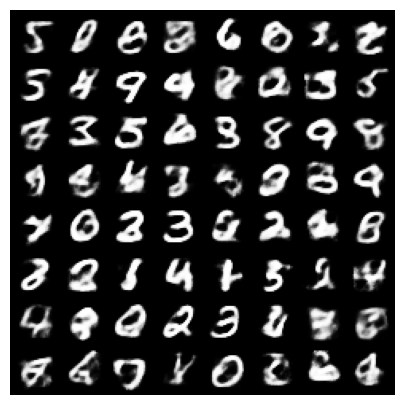

 20%|██        | 2/10 [01:26<05:47, 43.47s/it]

EPOCH: 3.000  val_recon: 723.164  val_loss: 1024.293  trn_kld: 302.740  val_mean: -0.004  trn_recon: 734.083  val_log_var: -0.185  trn_log_var: -0.186  val_kld: 301.129  trn_loss: 1036.824  (128.19s - 299.11s remaining)


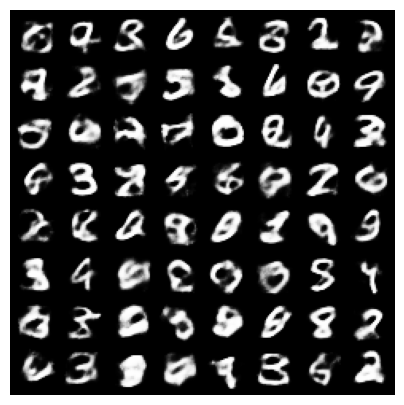

 30%|███       | 3/10 [02:08<04:58, 42.69s/it]

EPOCH: 4.000  val_recon: 722.278  val_loss: 1025.206  trn_kld: 303.136  val_mean: -0.004  trn_recon: 725.193  val_log_var: -0.192  trn_log_var: -0.186  val_kld: 302.928  trn_loss: 1028.329  (170.44s - 255.66s remaining)


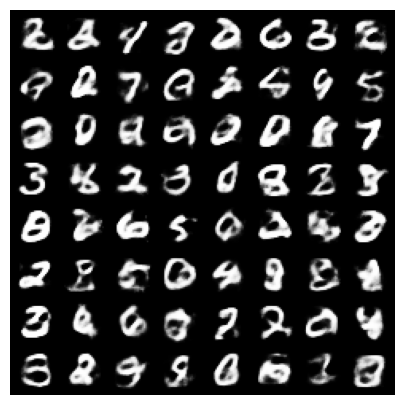

 40%|████      | 4/10 [02:50<04:15, 42.52s/it]

EPOCH: 5.000  val_recon: 719.674  val_loss: 1026.506  trn_kld: 303.472  val_mean: -0.004  trn_recon: 717.576  val_log_var: -0.185  trn_log_var: -0.187  val_kld: 306.832  trn_loss: 1021.048  (213.71s - 213.71s remaining)


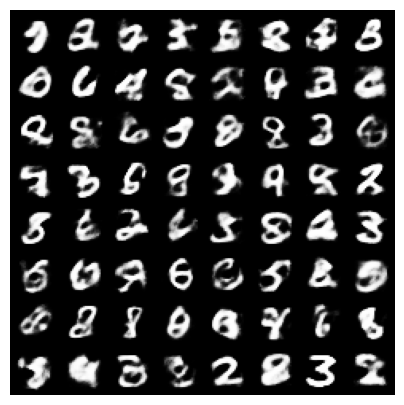

 50%|█████     | 5/10 [03:33<03:33, 42.79s/it]

EPOCH: 6.000  val_recon: 718.424  val_loss: 1017.536  trn_kld: 303.861  val_mean: -0.004  trn_recon: 710.433  val_log_var: -0.183  trn_log_var: -0.187  val_kld: 299.112  trn_loss: 1014.294  (256.27s - 170.84s remaining)


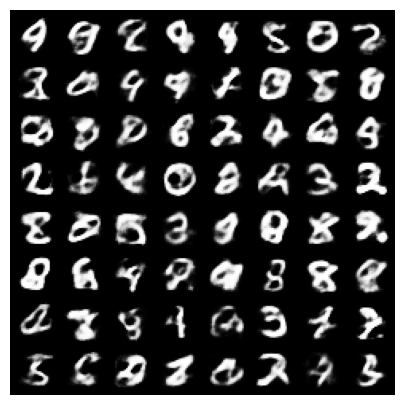

 60%|██████    | 6/10 [04:16<02:51, 42.85s/it]

EPOCH: 7.000  val_recon: 697.877  val_loss: 1007.724  trn_kld: 304.050  val_mean: -0.003  trn_recon: 703.153  val_log_var: -0.191  trn_log_var: -0.187  val_kld: 309.848  trn_loss: 1007.203  (299.21s - 128.23s remaining)


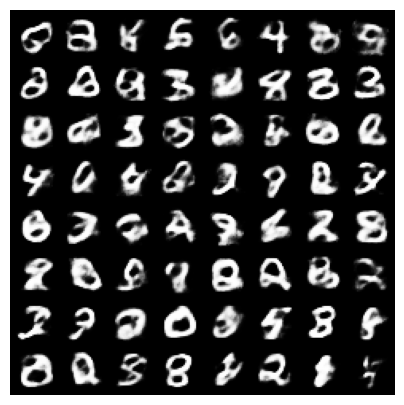

 70%|███████   | 7/10 [04:59<02:08, 42.75s/it]

EPOCH: 8.000  val_recon: 687.970  val_loss: 996.667  trn_kld: 304.234  val_mean: -0.004  trn_recon: 698.695  val_log_var: -0.193  trn_log_var: -0.187  val_kld: 308.697  trn_loss: 1002.929  (343.23s - 85.81s remaining)


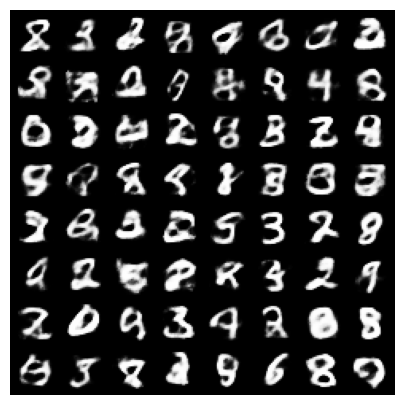

 80%|████████  | 8/10 [05:43<01:26, 43.15s/it]

EPOCH: 9.000  val_recon: 693.101  val_loss: 997.854  trn_kld: 304.508  val_mean: -0.005  trn_recon: 692.833  val_log_var: -0.186  trn_log_var: -0.188  val_kld: 304.753  trn_loss: 997.341  (386.47s - 42.94s remaining)


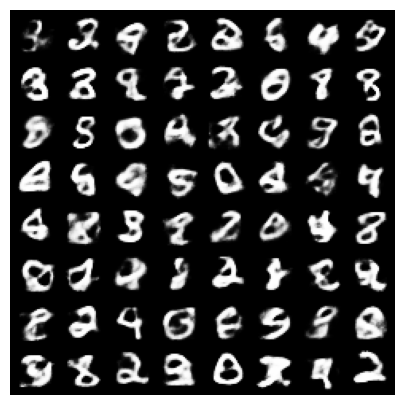

 90%|█████████ | 9/10 [06:26<00:43, 43.18s/it]

EPOCH: 10.000  val_recon: 693.016  val_loss: 993.157  trn_kld: 304.546  val_mean: -0.004  trn_recon: 687.505  val_log_var: -0.185  trn_log_var: -0.187  val_kld: 300.142  trn_loss: 992.051  (430.13s - 0.00s remaining)


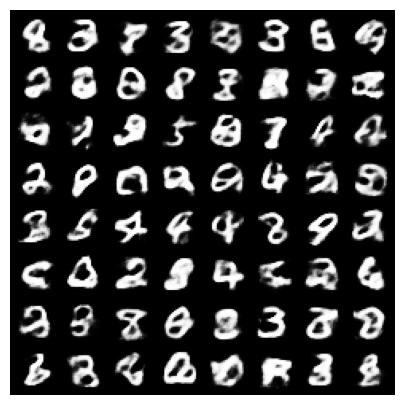

100%|██████████| 111/111 [00:00<00:00, 171.10it/s]


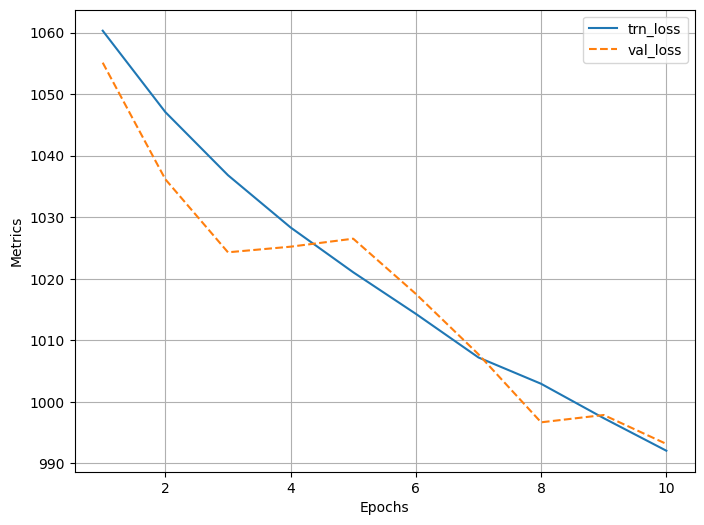

In [29]:
import tqdm
from tqdm import trange,tqdm
n_epochs = 10
log = Report(n_epochs)
for epoch in trange(n_epochs):
  N= len(trn_dl)
  for ix,(data,_) in enumerate(trn_dl):
    loss,recon,kld,log_var,mean = train_batch(data,vae,optimizer,loss_fn)
    log.record(pos=epoch+(ix+1)/N,
               trn_loss=loss,trn_kld=kld,
               trn_recon=recon,trn_log_var=log_var,val_mean = mean,end='\r')
  N = len(test_dl)
  for ix,(data,_) in  enumerate(test_dl):
    loss,recon,kld,log_var,mean = validate_batch(data,vae,loss_fn)
    log.record(pos=epoch+(ix+1)/N,
               val_loss=loss,val_kld=kld,
               val_recon=recon,val_log_var=log_var,val_mean = mean,end='\r')
  log.report_avgs(epoch+1)
  with torch.inference_mode():
    z = torch.randn(64,50).to(device)
    sample = vae.decoder(z).to(device)
    images = make_grid(sample.view(64,1,28,28)).permute(1,2,0)
    show(images)
log.plot_epochs(['trn_loss','val_loss'])